In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
import socket
# print(socket.gethostname())
import torch
print(torch.cuda.is_available())
# Which id has the current device
# print(torch.cuda.current_device())
# the name (type) of this device
# print(torch.cuda.get_device_name(0))
# how many devices are available in this session?
# print(torch.cuda.device_count())

/mnt/nfs/clustersw/Debian/stretch/JupyterPython/0.8/JupyterIST/bin/python3
3.8.3 (default, Jun 10 2020, 13:23:17) 
[GCC 10.1.0]
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)
True


In [2]:
import os
import glob
# import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
#import librosa
#import librosa.display
import requests
# import cv2

import torch.nn.functional as F
from torchvision.utils import save_image
from sklearn.metrics import r2_score 
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import VAE_functions as func
# from google.colab import drive

In [3]:
file_name = 'np_db_spec_10genres_99songs.npy'
audio_labels, spectrograms, genres = func.load_spectrograms(file_name)

In [4]:
batch_size = 10

In [5]:
train_dataset = func.SpectogramDataset(audio_labels, spectrograms, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 

valid_dataset = func.SpectogramDataset(audio_labels, spectrograms, valid=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = func.SpectogramDataset(audio_labels, spectrograms,)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

feature size: torch.Size([10, 1, 256, 640]) label size: torch.Size([10])


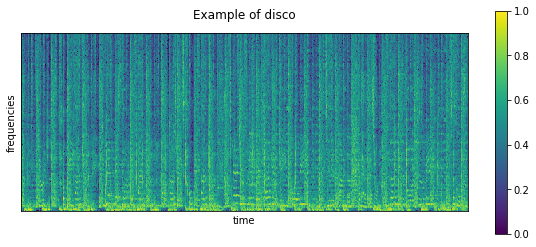

In [6]:
# @title Show Example input
train_features, train_labels = next(iter(train_dataloader))
print('feature size:', train_features.shape, 'label size:', train_labels.shape)
plt.matshow(train_features[0,0], origin='lower')
plt.colorbar()
plt.ylabel('frequencies')
plt.xlabel('time')
# genere_type = genres[int(np.where(train_labels[0] == 1)[0])]
# plt.title('Example of ' + genere_type)
plt.title('Example of ' + genres[int(train_labels[0])] )
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
# @title Set Device
device = func.Set_Device()

Device:  cuda


### Variation of learning rates

In [47]:
m_name = 'model_24821691_0.00167_0.pt'
o_name = 'output_24821691_0.pkl'
out_path = '/nfs/scistore08/kondrgrp/emaksimo/GTZAN/models/'
# torch.save(simple_model, out_path)
model = torch.load('{}{}'.format(out_path, m_name))
results = torch.load('{}{}'.format(out_path, o_name))

In [49]:
# res

In [51]:
# for res in results:
# func.plot_loss(res['train_loss'], res['validation_loss'], 
#            res['train_acc'], res['validation_acc'], 
#            res['num_epochs'], model)

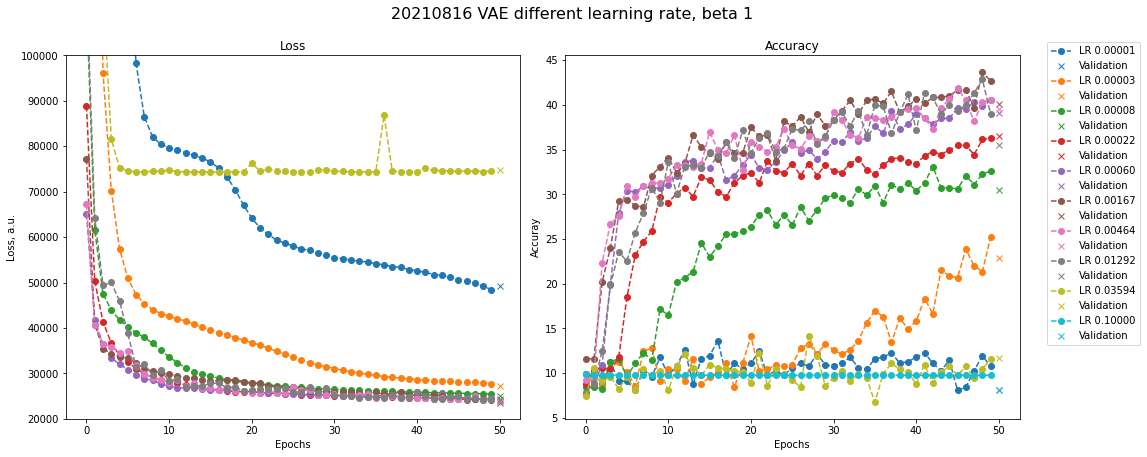

In [52]:
model.eval()
with torch.no_grad():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle('20210816 VAE different learning rate, beta 1', y = 1.05, fontsize = 16)
    label = 'Validation'
    for i, res in enumerate(results):
        
        train_loss = res['train_loss']
        validation_loss = res['validation_loss']
        train_acc = res['train_acc']
        validation_acc = res['validation_acc']
        num_epochs = res['num_epochs']
        
        ax[0].set_title('Loss')
        ax[0].plot(np.arange(num_epochs), np.array(train_loss), '--o', label = 'LR {:.5f}'.format(res['learning_rate']), c = 'C{}'.format(i))
        if len(validation_loss) == 1:
            ax[0].plot(num_epochs, validation_loss, 'x', label = label, c = 'C{}'.format(i))
        else:
            ax[0].plot(np.arange(num_epochs), validation_loss, '--o', label = label, c = 'C{}'.format(i))
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss, a.u.')

        ax[1].set_title('Accuracy')
        ax[1].plot(np.arange(num_epochs), train_acc, '--o', label = 'LR {:.5f}'.format(res['learning_rate']), c = 'C{}'.format(i))
        if len(validation_loss) == 1:
            ax[1].plot(num_epochs, validation_acc, 'x', label = label, c = 'C{}'.format(i))
        else:
            ax[1].plot(np.arange(num_epochs), validation_acc, '--o', label = label, c = 'C{}'.format(i))
        ax[1].legend(bbox_to_anchor=[1.05, 1.05])
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuray')
        ax[0].set_ylim(20000,100000)
    fig.tight_layout()

/mnt/nfs/clustersw/Debian/stretch/JupyterPython/0.8/JupyterIST/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


CPU times: user 848 ms, sys: 0 ns, total: 848 ms
Wall time: 138 ms
Compiler : 127 ms


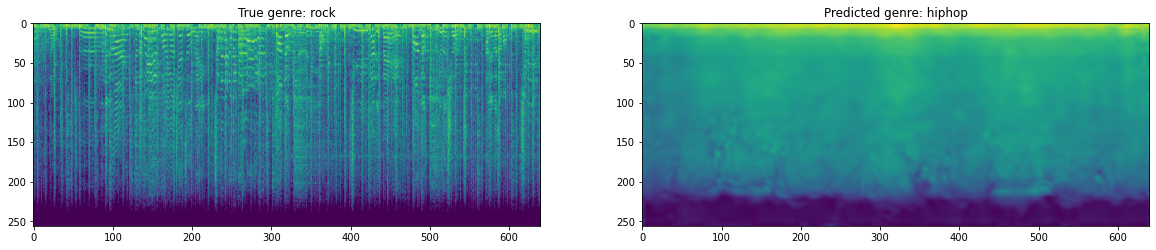

In [53]:
%%time
model.eval()
with torch.no_grad():
    for data in random.sample(list(test_dataloader), 1):
        imgs, labels = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.figure(figsize = (20,10))
        ax1 = plt.subplot(121)
        ax1.set_title('True genre: {}'.format(genres[int(labels[0])]))
        plt.imshow(np.squeeze(img))
        
        out, mu, logVAR, class_out = model(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        predicted_class = torch.argmax(class_out[0])
        ax2 = plt.subplot(122)
        ax2.set_title('Predicted genre: {}'.format(genres[int(predicted_class)]))
        plt.imshow(np.squeeze(outimg))
#         plt.colorbar()
        break

### Variation of beta


In [56]:
m_name = 'model_24824240_lr0.00170_b0.00046_0.pt'
o_name = 'output_24824240_1_10_0.pkl'
out_path = '/nfs/scistore08/kondrgrp/emaksimo/GTZAN/models/'
model = torch.load('{}{}'.format(out_path, m_name))
results = torch.load('{}{}'.format(out_path, o_name))

/mnt/nfs/clustersw/Debian/stretch/JupyterPython/0.8/JupyterIST/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/mnt/nfs/clustersw/Debian/stretch/JupyterPython/0.8/JupyterIST/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/mnt/nfs/clustersw/Debian/stretch/JupyterPython/0.8/JupyterIST/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source c

In [60]:
val_ac = np.empty(len(results))
for e, res in enumerate(results):
    val_ac[e] = res['validation_acc']

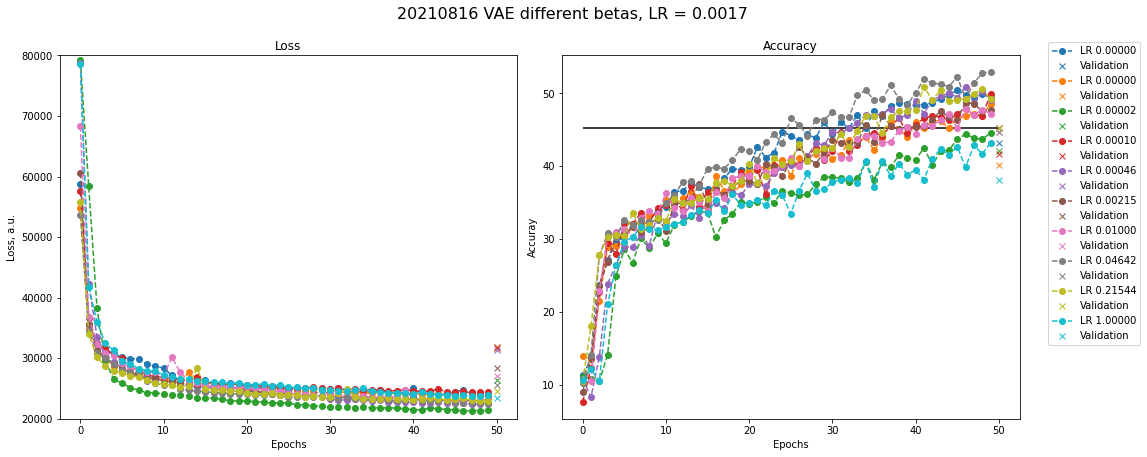

In [68]:
model.eval()
with torch.no_grad():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle('20210816 VAE different betas, LR = 0.0017', y = 1.05, fontsize = 16)
    label = 'Validation'
    for i, res in enumerate(results):
        
        train_loss = res['train_loss']
        validation_loss = res['validation_loss']
        train_acc = res['train_acc']
        validation_acc = res['validation_acc']
        num_epochs = res['num_epochs']
        
        
        ax[0].set_title('Loss')
        ax[0].plot(np.arange(num_epochs), np.array(train_loss), '--o', label = 'Beta {:.5f}'.format(res['beta']), c = 'C{}'.format(i))
        if len(validation_loss) == 1:
            ax[0].plot(num_epochs, validation_loss, 'x', label = label, c = 'C{}'.format(i))
        else:
            ax[0].plot(np.arange(num_epochs), validation_loss, '--o', label = label, c = 'C{}'.format(i))
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss, a.u.')

        ax[1].set_title('Accuracy')
        ax[1].plot(np.arange(num_epochs), train_acc, '--o', label = 'LR {:.5f}'.format(res['beta']), c = 'C{}'.format(i))
        if len(validation_loss) == 1:
            ax[1].plot(num_epochs, validation_acc, 'x', label = label, c = 'C{}'.format(i))
        else:
            ax[1].plot(np.arange(num_epochs), validation_acc, '--o', label = label, c = 'C{}'.format(i))
        ax[1].legend(bbox_to_anchor=[1.05, 1.05])
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuray')
        ax[0].set_ylim(20000,80000)
    val_max = np.max(val_ac)
    ax[1].hlines(val_max, 0, num_epochs, label = 'Max val accuracy, beta = {}'.format(results[np.argmax(val_ac)]['beta']))
    fig.tight_layout()

### Model performance on the test dataset

In [69]:
test_loss, test_r2, test_class_loss, test_acc = func.model_evaluation(model, 
                                                                 device, 
                                                                 test_dataloader, 
                                                                 res['learning_rate'], beta = 1)

/mnt/nfs/clustersw/Debian/stretch/JupyterPython/0.8/JupyterIST/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


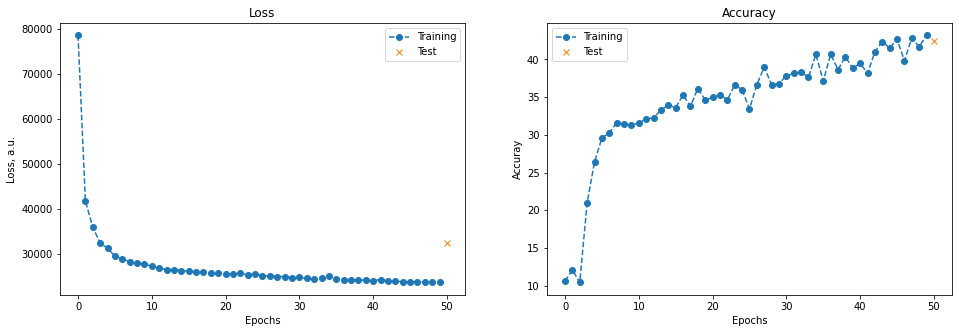

In [70]:
func.plot_loss(res['train_loss'], test_loss, 
               res['train_acc'], torch.stack(test_acc).cpu(), 
               res['num_epochs'], model, label = 'Test')

In [43]:
np.linspace(10,20, 1)

array([10.])

In [44]:
16e-4

0.0016